# Code to generate kaggle submission for basic\_conv\_net\_ (Net 2) and specialist network (Net 3)

#### Caution:  not pretty.  The model definitions needed to be recycled from other notebooks.  The tf.train.Saver() objects don't also save the network definitions, so there is a lot of recycled code, and probably some of it is extraneous.

In [1]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from decimal import *
import tensorflow as tf
import time
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected
import pandas as pd

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Loading Data

In [2]:
scott = True
aws = False
tensorboard_log = True

if scott:
    FROOT = ''
    FTRAIN = '/data/facial/training.csv'
    FTEST = '/data/facial/test.csv'
elif aws:
    FROOT = ''
    FTRAIN = '/data/training.csv'
    FTEST = '/data/test.csv'
else:
    FROOT = os.getcwd() # Path to your project folder
    FTRAIN = '~/notebooks/training.csv'
    FTEST = '~/notebooks/test.csv'

if tensorboard_log:
    root_logdir = FROOT + "tf_logs"
    
os.makedirs( FROOT + "/models/", exist_ok=True)

FLOOKUP = '/data/facial/IdLookupTable.csv'

#### Helper function to load data

In [3]:
np.random.seed(0)
def load(test = False, cols = None):
    '''Loads data from FTEST if *test* is true, otherwise from FTRAIN.' 
    Pass a list of *cols* if you are only interested in a
    subset of the target columns'''
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) #load pandas dataframe

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im,sep=' ')) 
    #image column has pixel values separated by space; convert the values to numpy arrays
    
    if cols: #get a subset of columns
        df = df[list(cols) + ['Image']]
        
    print('Count of observations in training data by features')
    print(df.count()) #prints number of values for each column
    df = df.dropna() #drop all rows that have missing values in them
    
    X = np.vstack(df['Image'].values)/255
    X = X.astype(np.float32)
    
    if not test:
        y  = df[df.columns[:-1]].values
        y = (y-48)/48
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
        y = y.astype(np.float32)
    else:
        y = None
    print('done')
        
    return X,y


In [4]:
# Load data

np.random.seed(0)
X, y = load()

print('Total training data')
print("X.shape = = {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(),X.max()))
print("y.shape = = {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(),y.max()))

dev_size = 0.2
#setting aside a 20% sample for validation

x_train, x_dev, y_train, y_dev = train_test_split(X, y, test_size = dev_size)

x_test, _ = load(test=True)

print('Training data split into train and dev data')
print("x_train.shape = = {}; x_train.min == {:.3f}; x_train.max == {:.3f}".format(x_train.shape, x_train.min(),x_train.max()))
print("y_train.shape = = {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(y_train.shape, y_train.min(),y_train.max()))
print("x_dev.shape = = {}; x_dev.min == {:.3f}; x_dev.max == {:.3f}".format(x_dev.shape, x_dev.min(),x_dev.max()))
print("y_dev.shape = = {}; y_dev.min == {:.3f}; y_dev.max == {:.3f}".format(y_dev.shape, y_dev.min(),y_dev.max()))

Count of observations in training data by features
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       22

In [5]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [6]:
# *might* need to double check correctly formatted input
def plot_loss (train_loss_data, dev_loss_data):
    
    plt.figure()
    plt.plot(train_loss_data[:,1], label="train")
    plt.plot(dev_loss_data[:,1], linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.show()

In [7]:
# *might* need to double check correctly formatted input
def plot_pred (x_dev, y_pred):
    
    fig = plt.figure(figsize=(16, 16))
    fig.subplots_adjust(
        left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(4):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plot_sample(x_dev[i], y_pred[i], ax)
    plt.show
    


# Restore basic\_conv\_net\_ from checkpoint and predict from test data

In [8]:
unique_name = ""
model_name = "basic_conv_net_" + unique_name
model_path =  FROOT + "/models/"+ model_name + "/model.ckpt"
train_history_path = FROOT + "/models/" + model_name + "/train_history"

In [9]:
learning_rate = 0.01
momentum = 0.9
# optimizer used
optimize_func = tf.train.MomentumOptimizer
# (learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

n_epochs = 1501 #Standardizing to 1000 epochs for all networks (except some coarse testing)
batch_size = 128

n_inputs = X.shape[1] 
n_outputs = 30


# Convolutional Layer 1.
filter_size1 = 3          # Convolution filters are 3 x 3 pixels.
num_filters1 = 32         # There are 32 of these filters.
dropout_keep_prob1 = 1


# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 64         # There are 64 of these filters.
dropout_keep_prob2 = 1


# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 128         # There are 128 of these filters.
dropout_keep_prob3 = 1


# Fully-connected layer.
fc_size4 = 1000             # Number of output neurons in fully-connected layer1.
dropout_keep_prob4 = 1      # Drop about keep robability if drop outs are applied
fc_size5 = 1000             # Number of output neurons in fully-connected layer2.
dropout_keep_prob5 = 1
dropout_keep_prob6 = 1

## Helper functions to redefine network

In [10]:
#Defining a leaky relu activation function using the relu activation function in tensorflow.
def lrelu(x, alpha=0.05):
  return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

In [11]:
#Building a convolutional layer
#Note : uncomment the layer = lrelu(layer) when running that option.


def new_conv_relu_layer(input, filter_size, num_filters, is_training, dropout_keep_prob = 1):
    """Takes parameters and set up a convoluted layer with possible pooling
    It returns the layer as well as the weights"""

    weights = tf.get_variable( 'weights', 
        shape = [filter_size, filter_size, input.get_shape()[3], num_filters],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    
    biases = tf.get_variable( 'biases',
        shape = [num_filters],
        initializer=tf.constant_initializer(0.0)
      )
    
    conv = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    
    
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')


    layer += biases

    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME')

    #layer = tf.nn.relu(layer)
    layer = lrelu(layer)
    
    # apply drop out by specifying a drop_out_keep_prob
    layer = tf.cond(is_training, lambda: tf.nn.dropout(layer, keep_prob = dropout_keep_prob), lambda: layer)
    
    return layer, weights

In [12]:
#Building a fully connected layer, with relu
#Note : uncomment the layer = lrelu(layer) when running that option.

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu,
                 is_training ,
                 dropout_keep_prob = 1):       # no relu for the output dense layer

    # Create new weights and biases.
    weights = tf.get_variable( 'weights', 
        shape = [num_inputs, num_outputs],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    
    biases = tf.get_variable( 'biases',
        shape = [num_outputs],
        initializer=tf.constant_initializer(0.0)
      )
        

    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        #layer = tf.nn.relu(layer)
        layer = lrelu(layer)
    
    layer = tf.cond(is_training, lambda: tf.nn.dropout(layer, keep_prob = dropout_keep_prob), lambda: layer)

    return layer

In [13]:
# build flatten layer function to flatten conv layer for the fully connected layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

### Definition of Net 2

INFO:tensorflow:Restoring parameters from /models/basic_conv_net_/model.ckpt
Train history file: /models/basic_conv_net_/train_history
done


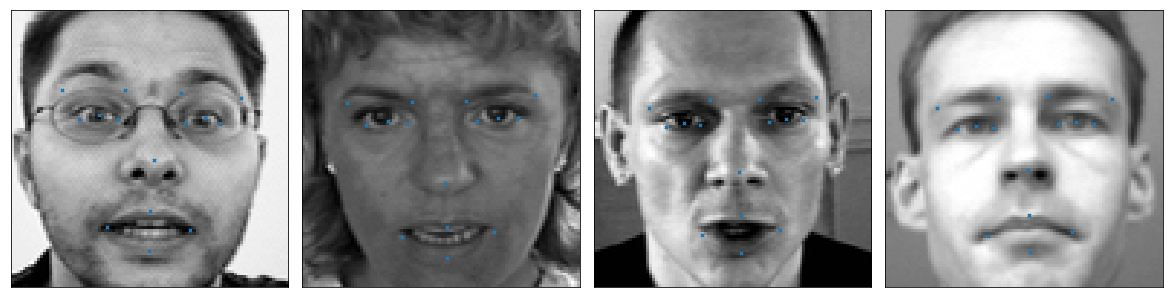

In [14]:
#Net 2 as baseline and starting point for net 3
np.random.seed(1)
graph_base = tf.Graph()
n_epochs = 2001 # resetting n_epochs back to max after testing different filter sizes. needs to be consistent for this and net 3.
#changing keep_prob values
dropout_keep_prob1 = 1.0
dropout_keep_prob2 = 1.0
dropout_keep_prob3 = 1.0
dropout_keep_prob4 = 0.7
dropout_keep_prob5 = 0.7
#Setting filters to best value from trying with net 2
num_filters1 = 3
num_filters2 = 2
num_filters3 = 2

with graph_base.as_default():

    # def 
    # is_train = True
    #input data
    X = tf.placeholder(tf.float32,[None,X.shape[1]])
    y = tf.placeholder(tf.float32,[None,y.shape[1]])
    training = tf.placeholder(tf.bool)
    
    current_epoch = tf.Variable(0)

    #convert x into 4-D input
    #2nd and 3rd dimension is image width and height, final dimension is number of color channels
    x_image = tf.reshape(X,[-1,96,96,1]) 

    #First convolutional layer
    with tf.variable_scope('conv1'):
        layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

    #Second convolutional layer
    with tf.variable_scope('conv2'):
        layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

    #Thrid convolutional layer
    with tf.variable_scope('conv3'):
        layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

    #Flatten conv3 output for dense nn layer 1
    layer_flat, num_features = flatten_layer(layer_conv3)

    #Densely connected layer1
    with tf.variable_scope('fc4'):
        layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

    #Densely connected layer2
    with tf.variable_scope('fc5'):
        layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

    #Densely connected output layer
    with tf.variable_scope('fc6'):
        layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = n_outputs,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


    #loss function
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(np.square(layer_f6 - y))
        sqrt_loss = tf.sqrt(loss)
        
    #for tensorboard
#    with tf.name_scope('summaries'):
#        sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)

        
    # optimizer
    current_epoch = tf.Variable(0.0)
    m_min = 0.9
    m_max = 0.99
    momentum = m_min + (m_max-m_min)*current_epoch/n_epochs
    lr_min = 0.01
    lr_max = 0.03
    learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps=n_epochs, decay_rate=0.03)
    optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

    train_loss_data = np.zeros((n_epochs,2))
    dev_loss_data = np.zeros((n_epochs,2))
    y_pred = np.zeros((x_test.shape[0],y.shape[1]))

    
time_start = time.time()
time_1000_start = time.time()

    
with tf.Session(graph=graph_base) as sess:
#    sess.run(tf.global_variables_initializer())
    
    #for restoring model 
    saver = tf.train.Saver()
    
    
    
    ##############################
    #Load saved model

    unique_name = ""
    model_name = "basic_conv_net_" + unique_name
    model_path =  FROOT + "/models/"+ model_name + "/model.ckpt"
    train_history_path = FROOT + "/models/" + model_name + "/train_history"
    save_path = saver.restore(sess, model_path)
    print("Train history file: " + train_history_path)
    ##############################
    
    
    ###############################
    # Predictions are here
    for i in range(int(x_test.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_test[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})
    X_batch_last = x_test[(i+1)*batch_size:,:]
    y_pred [(i+1) * batch_size:] = sess.run(layer_f6,feed_dict = {X:X_batch_last, training:False})
    print('done')
    ###############################        
        
#Plot faces with predictions:
    

plot_pred (x_test, y_pred)


In [15]:
# this is ONLY to load the column names in order.  Inefficient
test = False
fname = FTEST if test else FTRAIN
df = read_csv(os.path.expanduser(fname), ) #load pandas dataframe
lookup_table = read_csv(FLOOKUP)

In [16]:
y_pred_int = np.int16(np.round(y_pred * 48 + 48, decimals=0))

In [17]:
column_names = df.columns
column_names = list(column_names[:-1])

In [18]:
column_names

['left_eye_center_x',
 'left_eye_center_y',
 'right_eye_center_x',
 'right_eye_center_y',
 'left_eye_inner_corner_x',
 'left_eye_inner_corner_y',
 'left_eye_outer_corner_x',
 'left_eye_outer_corner_y',
 'right_eye_inner_corner_x',
 'right_eye_inner_corner_y',
 'right_eye_outer_corner_x',
 'right_eye_outer_corner_y',
 'left_eyebrow_inner_end_x',
 'left_eyebrow_inner_end_y',
 'left_eyebrow_outer_end_x',
 'left_eyebrow_outer_end_y',
 'right_eyebrow_inner_end_x',
 'right_eyebrow_inner_end_y',
 'right_eyebrow_outer_end_x',
 'right_eyebrow_outer_end_y',
 'nose_tip_x',
 'nose_tip_y',
 'mouth_left_corner_x',
 'mouth_left_corner_y',
 'mouth_right_corner_x',
 'mouth_right_corner_y',
 'mouth_center_top_lip_x',
 'mouth_center_top_lip_y',
 'mouth_center_bottom_lip_x',
 'mouth_center_bottom_lip_y']

In [19]:
df_pred = pd.DataFrame(y_pred_int, columns=column_names)

In [20]:
df_pred

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,67,37,30,36,60,39,72,39,37,37,...,49,52,62,76,33,75,48,69,47,83
1,67,37,29,38,60,38,74,37,36,39,...,49,59,66,76,34,78,49,75,49,85
2,66,37,31,39,60,38,72,38,36,39,...,50,56,64,76,37,77,50,71,50,84
3,66,38,31,40,59,39,72,39,37,40,...,49,55,64,77,35,78,49,71,50,83
4,67,38,28,39,60,38,73,38,35,39,...,49,55,65,77,35,78,49,71,50,86
5,66,38,30,38,59,39,72,39,36,38,...,48,55,62,75,33,76,48,71,48,83
6,68,36,28,36,60,36,76,36,35,36,...,50,54,65,76,31,77,48,72,49,85
7,67,37,29,36,61,37,74,37,36,38,...,49,54,64,74,34,74,49,70,49,82
8,66,39,30,37,60,39,72,40,37,38,...,47,56,61,77,31,76,47,71,46,85
9,66,37,30,36,60,38,73,38,36,37,...,49,55,63,73,33,73,48,68,48,82


In [21]:
values = []

for index, row in lookup_table.iterrows():
    values.append((
        row['RowId'],
        df_pred.loc[row.ImageId - 1][row.FeatureName],
        ))

In [22]:
values

[(1, 67),
 (2, 37),
 (3, 30),
 (4, 36),
 (5, 60),
 (6, 39),
 (7, 72),
 (8, 39),
 (9, 37),
 (10, 37),
 (11, 23),
 (12, 37),
 (13, 58),
 (14, 28),
 (15, 79),
 (16, 30),
 (17, 39),
 (18, 27),
 (19, 17),
 (20, 27),
 (21, 49),
 (22, 52),
 (23, 62),
 (24, 76),
 (25, 33),
 (26, 75),
 (27, 48),
 (28, 69),
 (29, 47),
 (30, 83),
 (31, 67),
 (32, 37),
 (33, 29),
 (34, 38),
 (35, 60),
 (36, 38),
 (37, 74),
 (38, 37),
 (39, 36),
 (40, 39),
 (41, 22),
 (42, 40),
 (43, 56),
 (44, 31),
 (45, 80),
 (46, 29),
 (47, 38),
 (48, 31),
 (49, 15),
 (50, 32),
 (51, 49),
 (52, 59),
 (53, 66),
 (54, 76),
 (55, 34),
 (56, 78),
 (57, 49),
 (58, 75),
 (59, 49),
 (60, 85),
 (61, 66),
 (62, 37),
 (63, 31),
 (64, 39),
 (65, 60),
 (66, 38),
 (67, 72),
 (68, 38),
 (69, 36),
 (70, 39),
 (71, 24),
 (72, 40),
 (73, 57),
 (74, 30),
 (75, 76),
 (76, 30),
 (77, 40),
 (78, 31),
 (79, 19),
 (80, 34),
 (81, 50),
 (82, 56),
 (83, 64),
 (84, 76),
 (85, 37),
 (86, 77),
 (87, 50),
 (88, 71),
 (89, 50),
 (90, 84),
 (91, 66),
 (92, 38

In [23]:
now_str = datetime.now().isoformat().replace(':', '-')
submission = pd.DataFrame(values, columns=('RowId', 'Location'))

filename =  FROOT + "/models/"+ model_name + '/submission-{}.csv'.format(now_str)

submission.to_csv(filename, index=False)
print("Wrote {}".format(filename))

Wrote /models/basic_conv_net_/submission-2017-12-14T18-44-32.270676.csv


### Define network3 for reloading of parameters

In [24]:
#Uncomment the dict to run a particular model
facial_group_labels = [
   
    dict(
        name = "mouth_corner_top",
        columns = (
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            )),
     
     dict(
         name = "nose_tip",
         columns = (
             'nose_tip_x', 'nose_tip_y',
             )),

    dict(
        name = "mouth_bottom",
        columns = (
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            )),

    dict(
        name = "eye_corner",
        columns = (
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            )),

    dict(
        name = "eyebrow",
        columns = (
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            )),
    
     dict(
        name = "eye_center",
        columns = (
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            )),
    ]

In [25]:
def test_individual_model(facial_model_label):
    
    np.random.seed(1)
    graph_base = tf.Graph()
    
    X, y = load(cols = facial_model_label['columns'])
    num_keypoints = y.shape[1]
    
    
    
    np.random.seed(0)
    dev_size = 0.2
    #setting aside a 20% sample for validation

    x_train, x_dev, y_train, y_dev = train_test_split(X, y, test_size = dev_size)

    x_test, _ = load(test=True)

    print('Training data split into train and dev data')
    print("x_train.shape = = {}; x_train.min == {:.3f}; x_train.max == {:.3f}".format(x_train.shape, x_train.min(),x_train.max()))
    print("y_train.shape = = {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(y_train.shape, y_train.min(),y_train.max()))
    print("x_dev.shape = = {}; x_dev.min == {:.3f}; x_dev.max == {:.3f}".format(x_dev.shape, x_dev.min(),x_dev.max()))
    print("y_dev.shape = = {}; y_dev.min == {:.3f}; y_dev.max == {:.3f}".format(y_dev.shape, y_dev.min(),y_dev.max()))
    
    with graph_base.as_default():

        if tensorboard_log:
            now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
            logdir = "{}/run-{}/".format(root_logdir, now)

    
        X = tf.placeholder(tf.float32,[None,X.shape[1]])
        y = tf.placeholder(tf.float32,[None,y.shape[1]])
        training = tf.placeholder(tf.bool)
        current_epoch = tf.Variable(0)  # count the number of epochs
    
        #convert x into 4-D input
        #2nd and 3rd dimension is image width and height, final dimension is number of color channels
        x_image = tf.reshape(X,[-1,96,96,1]) 
    
        

        #First convolutional layer
        with tf.variable_scope('conv1'):
            layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

        #Second convolutional layer
        with tf.variable_scope('conv2'):
            layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

        #Thrid convolutional layer
        with tf.variable_scope('conv3'):
            layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

        #Flatten conv3 output for dense nn layer 1
        layer_flat, num_features = flatten_layer(layer_conv3)

        #Densely connected layer1
        with tf.variable_scope('fc4'):
            layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

        #Densely connected layer2
        with tf.variable_scope('fc5'):
            layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

        #Densely connected output layer
        with tf.variable_scope('fc6'):
            layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = num_keypoints,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


        #loss function
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(np.square(layer_f6 - y))
            sqrt_loss = tf.sqrt(loss)
        
        #for tensorboard
        with tf.name_scope('summaries'):
            sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)
    
        # optimizer
        #making changes to learning rate and momentum for individual models
        # learning rate decay. - Idea is to start with high learning rate to speed up but decrease as we get closer to 
        #the local optimum so that we don't surpass it.
        learning_rate = tf.train.exponential_decay(0.08, current_epoch, decay_steps = n_epochs, decay_rate = 0.03)
        momentum = 0.9 + (0.99 - 0.9) * (current_epoch / n_epochs)
        optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

        train_loss_data = np.zeros((n_epochs,2))
        dev_loss_data = np.zeros((n_epochs,2))
        y_pred = np.zeros((x_test.shape[0],y.shape[1]))

        # logger
        if tensorboard_log:
            train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
            dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
    time_start = time.time()
    time_1000_start = time.time()

    
    with tf.Session(graph=graph_base) as sess:
        initialising_model = "basic_conv_net_"
        
        #################################
        # Load past model for prediction
        
        saver = tf.train.Saver()
        model_name = "ind_model_" + facial_model_label['name'] + "_"
        model_path =  FROOT + "/models/"+ model_name + "/model.ckpt"
        train_history_path = FROOT + "/models/" + model_name + "/train_history"
        loader = saver.restore(sess, model_path)
    
        for i in range(int(x_test.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_test[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})
        X_batch_last = x_test[(i+1)*batch_size:,:]
        y_pred [(i+1) * batch_size:] = sess.run(layer_f6,feed_dict = {X:X_batch_last, training:False})
        return y_pred

        plot_pred (x_test, y_pred)


In [26]:
start = time.time()

df_pred2 = pd.DataFrame()

for facial_model_label in facial_group_labels:
    y_preds = test_individual_model(facial_model_label)
    these_cols = facial_model_label['columns']
    for idx, column in enumerate(these_cols):
        df_pred2[column] = y_preds[:, idx]
    
time_stop = time.time()    
print(" Total time for all models: " , time_stop - start)

Count of observations in training data by features
mouth_left_corner_x       2269
mouth_left_corner_y       2269
mouth_right_corner_x      2270
mouth_right_corner_y      2270
mouth_center_top_lip_x    2275
mouth_center_top_lip_y    2275
Image                     7049
dtype: int64
done
Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
done
Training data split into train and dev data
x_train.shape = = (1808, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (1808, 6); y_train.min == -0.942; y_train.max == 0.990
x_dev.shape = = (452, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (452, 6); y_dev.min == -0.953; y_dev.max == 0.961
INFO:tensorflow:Restoring parameters from /models/ind_model_mouth_corner_top_/model.ckpt
Count of observations in training data by features
nose_tip_x    7049
nose_tip_y    7049
Image         7049
dtype: int64
done
Count of observations in training data by features
ImageId    1783
Image

In [27]:
df_pred2

,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,...,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y
0,0.316279,0.572083,-0.308630,0.571952,0.015815,0.440688,0.062845,0.140268,0.004408,0.756725,...,-0.189529,-0.401602,0.649365,-0.374326,-0.644215,-0.424545,0.369496,-0.209699,-0.373239,-0.227157
1,0.349874,0.578655,-0.293233,0.593191,0.026209,0.516103,0.027163,0.228810,0.049332,0.787158,...,-0.218352,-0.329164,0.667672,-0.400389,-0.704955,-0.327095,0.398426,-0.241899,-0.401726,-0.233966
2,0.327717,0.565990,-0.243894,0.585731,0.036133,0.496088,0.007109,0.175338,0.018776,0.711026,...,-0.172781,-0.366227,0.592914,-0.398556,-0.605506,-0.311118,0.384062,-0.236297,-0.347162,-0.209406
3,0.359187,0.624938,-0.295417,0.640904,0.014431,0.498588,0.011440,0.158881,0.004407,0.697442,...,-0.206520,-0.349192,0.597224,-0.363726,-0.637105,-0.299447,0.371386,-0.201074,-0.344891,-0.167121
4,0.328981,0.617667,-0.262875,0.616546,0.024380,0.481487,0.018812,0.148849,0.008515,0.766250,...,-0.230018,-0.406194,0.657441,-0.376685,-0.682422,-0.352822,0.389679,-0.209125,-0.394408,-0.180029
5,0.321151,0.567825,-0.309234,0.581955,0.007197,0.473839,0.002914,0.110287,0.008422,0.749251,...,-0.159047,-0.362101,0.648010,-0.376284,-0.673222,-0.345302,0.400677,-0.199957,-0.370217,-0.205208
6,0.351163,0.572230,-0.384793,0.579597,0.007395,0.525516,0.054600,0.265211,0.015621,0.696311,...,-0.220480,-0.467644,0.692207,-0.431776,-0.765397,-0.433851,0.396497,-0.258933,-0.451843,-0.239993
7,0.344962,0.533316,-0.261050,0.557887,0.045368,0.444526,0.053304,0.112734,0.042211,0.701839,...,-0.198114,-0.365627,0.661414,-0.372805,-0.649925,-0.358503,0.405686,-0.239945,-0.380959,-0.237517
8,0.292127,0.596982,-0.340263,0.582769,-0.024048,0.481204,-0.022969,0.195614,-0.031017,0.780719,...,-0.138549,-0.373265,0.654719,-0.306154,-0.634470,-0.376032,0.359609,-0.184738,-0.347417,-0.215195
9,0.319187,0.527274,-0.333599,0.524151,-0.003747,0.405708,0.018672,0.126793,0.004053,0.708413,...,-0.198380,-0.458929,0.651748,-0.400603,-0.662286,-0.381725,0.385032,-0.234922,-0.379349,-0.245113


In [28]:
df_pred3 = df_pred2.applymap(lambda v: v*48 + 48)

In [29]:
df_pred3 = df_pred3.applymap(lambda v: np.int8(np.round(v, decimals = 0)))
df_pred3

,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,...,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y
0,63,75,33,75,49,69,51,55,48,84,...,39,29,79,30,17,28,66,38,30,37
1,65,76,34,76,49,73,49,59,50,86,...,38,32,80,29,14,32,67,36,29,37
2,64,75,36,76,50,72,48,56,49,82,...,40,30,76,29,19,33,66,37,31,38
3,65,78,34,79,49,72,49,56,48,81,...,38,31,77,31,17,34,66,38,31,40
4,64,78,35,78,49,71,49,55,48,85,...,37,29,80,30,15,31,67,38,29,39
5,63,75,33,76,48,71,48,53,48,84,...,40,31,79,30,16,31,67,38,30,38
6,65,75,30,76,48,73,51,61,49,81,...,37,26,81,27,11,27,67,36,26,36
7,65,74,35,75,50,69,51,53,50,82,...,38,30,80,30,17,31,67,36,30,37
8,62,77,32,76,47,71,47,57,47,85,...,41,30,79,33,18,30,65,39,31,38
9,63,73,32,73,48,67,49,54,48,82,...,38,26,79,29,16,30,66,37,30,36


In [30]:
values = []

for index, row in lookup_table.iterrows():
    values.append((
        row['RowId'],
        df_pred3.loc[row.ImageId - 1][row.FeatureName],
        ))
    
now_str = datetime.now().isoformat().replace(':', '-')
submission = pd.DataFrame(values, columns=('RowId', 'Location'))

filename =  FROOT + "/models/"+ model_name + '/submission-{}.csv'.format(now_str)

submission.to_csv(filename, index=False)
print("Wrote {}".format(filename))

Wrote /models/basic_conv_net_/submission-2017-12-14T18-45-56.245034.csv
